In [51]:
from google.colab import files
uploaded = files.upload()

Saving Legal-Clause-Dataset.zip to Legal-Clause-Dataset (1).zip


In [52]:
import os, zipfile


RAW_DATA_DIR = "/content/legal_clause_raw"
os.makedirs(RAW_DATA_DIR, exist_ok=True)


zip_name = list(uploaded.keys())[0]
print("Uploaded:", zip_name)


with zipfile.ZipFile(zip_name, "r") as z:
    z.extractall(RAW_DATA_DIR)

print("Unzipped to:", RAW_DATA_DIR)


Uploaded: Legal-Clause-Dataset (1).zip
Unzipped to: /content/legal_clause_raw


In [53]:
import glob, os

csvs = glob.glob(os.path.join(RAW_DATA_DIR, "*.csv"))

print("CSV files found:", len(csvs))
print("Examples:", [os.path.basename(p) for p in csvs[:5]])


CSV files found: 395
Examples: ['organization.csv', 'independent-contractor.csv', 'registration-rights.csv', 'amendments-and-waivers.csv', 'term-of-employment.csv']


In [54]:

import os, sys, random, math, json, itertools, re, time, glob, zipfile, shutil
import numpy as np
import pandas as pd
from typing import List, Tuple, Dict

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, average_precision_score,
                             confusion_matrix, roc_curve, precision_recall_curve)

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print("TF version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))


TF version: 2.19.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [55]:
SEED = 42
random.seed(SEED); np.random.seed(SEED); tf.random.set_seed(SEED)

# Vectorization / sequence settings
MAX_TOKENS     = 20000      # vocabulary size
SEQ_LEN        = 128        # padded length

# Pair dataset split & balance
TEST_SIZE      = 0.15
VAL_SIZE       = 0.15       # of TRAIN portion
NEG_MULTIPLIER = 1.0        # negatives per positive (≈ 50/50)

# Training
BATCH_SIZE     = 128
EPOCHS         = 15
PATIENCE       = 3
LR             = 1e-3

# Paths
BASE_DIR       = "/content"
RAW_DATA_DIR   = os.path.join(BASE_DIR, "legal_clause_raw")   # your CSVs here
WORK_DIR       = os.path.join(BASE_DIR, "legal_clause_work")
ART_DIR        = os.path.join(WORK_DIR, "artifacts")
os.makedirs(RAW_DATA_DIR, exist_ok=True)
os.makedirs(WORK_DIR, exist_ok=True)
os.makedirs(ART_DIR, exist_ok=True)

print("RAW_DATA_DIR:", RAW_DATA_DIR)


RAW_DATA_DIR: /content/legal_clause_raw


In [56]:
csvs = glob.glob(os.path.join(RAW_DATA_DIR, "*.csv"))

print("CSV files found:", len(csvs))
print("Example files:", [os.path.basename(p) for p in csvs[:5]])

assert len(csvs) > 0, "No CSV files found in RAW_DATA_DIR. Please upload/unzip first."


CSV files found: 395
Example files: ['organization.csv', 'independent-contractor.csv', 'registration-rights.csv', 'amendments-and-waivers.csv', 'term-of-employment.csv']


In [59]:
def load_all_clause_csvs(data_dir: str) -> pd.DataFrame:

    rows = []
    for path in glob.glob(os.path.join(data_dir, "*.csv")):
        try:
            df = pd.read_csv(path)
        except Exception as e:
            print("Skipping (read error):", path, e); continue

        df.columns = [c.lower().strip() for c in df.columns]

        # find text column
        text_col = None
        for cand in ["clause_text","text","clause","clausebody","clause_texts"]:
            if cand in df.columns: text_col = cand; break
        if text_col is None:
            # pick the column with largest avg string length
            text_col = max(df.columns, key=lambda c: df[c].astype(str).str.len().mean())

        # find label column or fallback to filename
        label_col = None
        for cand in ["clause_type","label","type","category"]:
            if cand in df.columns: label_col = cand; break
        if label_col is None:
            label_col = "__filename"
            df[label_col] = os.path.basename(path).replace(".csv","")

        tidy = df[[text_col,label_col]].dropna()
        tidy.columns = ["clause_text", "clause_type"]
        tidy["clause_text"] = tidy["clause_text"].astype(str).str.strip()
        tidy = tidy[tidy["clause_text"].str.len() > 0]
        rows.append(tidy)

    all_df = pd.concat(rows, axis=0, ignore_index=True)
    print("Loaded clauses:", len(all_df), " | categories:", all_df["clause_type"].nunique())
    return all_df

clauses_df = load_all_clause_csvs(RAW_DATA_DIR)
clauses_df.head()


Loaded clauses: 150881  | categories: 395


,clause_text,clause_type
0,Organization. Buyer is a corporation duly orga...,organization
1,Organization. Buyer is a corporation duly orga...,organization
2,Organization. The Company and each of its Subs...,organization
3,Organization. The Company is a corporation dul...,organization
4,Organization. ZiaSun is a corporation duly org...,organization


In [60]:

from itertools import combinations
import numpy as np
import pandas as pd

def make_pairs(df: pd.DataFrame, neg_multiplier: float = 1.0, seed: int = 42) -> pd.DataFrame:
    """
    Faster, capped pair-builder:
    - Samples up to MAX_ITEMS_PER_CAT items per class
    - Creates up to MAX_POS_PER_CAT positive pairs per class
    - Enforces a GLOBAL_POS_CAP across all positives
    - Negatives are sampled uniformly across different classes
    """

    MAX_ITEMS_PER_CAT = 150
    MAX_POS_PER_CAT   = 8000
    GLOBAL_POS_CAP    = 150_000

    rng = np.random.default_rng(seed)

    # 1) Collect texts per category with item cap
    by_cat = {}
    for cat, sub in df.groupby("clause_type"):
        items = sub["clause_text"].dropna().astype(str).tolist()
        if not items:
            continue
        if len(items) > MAX_ITEMS_PER_CAT:
            items = rng.choice(items, size=MAX_ITEMS_PER_CAT, replace=False).tolist()
        by_cat[cat] = items

    cats = list(by_cat.keys())

    # 2) Build positive pairs with per-class + global caps
    pos_pairs = []
    for cat in cats:
        items = by_cat[cat]
        n = len(items)
        if n < 2:
            continue

        idx_pairs = list(combinations(range(n), 2))  # n*(n-1)/2
        if len(idx_pairs) > MAX_POS_PER_CAT:
            keep = rng.choice(len(idx_pairs), size=MAX_POS_PER_CAT, replace=False)
            idx_pairs = [idx_pairs[i] for i in keep]

        for i, j in idx_pairs:
            pos_pairs.append((items[i], items[j], 1))

        if len(pos_pairs) >= GLOBAL_POS_CAP:
            pos_pairs = pos_pairs[:GLOBAL_POS_CAP]
            break

    n_pos = len(pos_pairs)

    # 3) Negatives to match multiplier
    n_neg_target = int(n_pos * neg_multiplier)
    neg_pairs = []
    if len(cats) >= 2 and n_neg_target > 0:
        cat_lengths = {c: len(by_cat[c]) for c in cats}
        while len(neg_pairs) < n_neg_target:
            c1, c2 = rng.choice(cats, size=2, replace=False)
            if cat_lengths[c1] == 0 or cat_lengths[c2] == 0:
                continue
            t1 = by_cat[c1][rng.integers(cat_lengths[c1])]
            t2 = by_cat[c2][rng.integers(cat_lengths[c2])]
            neg_pairs.append((t1, t2, 0))

    # 4) Combine & shuffle
    pair_df = pd.DataFrame(pos_pairs + neg_pairs, columns=["t1","t2","label"])
    pair_df = pair_df.sample(frac=1.0, random_state=seed).reset_index(drop=True)
    print(f"Pairs built — total={len(pair_df)} | positives={n_pos} | negatives={len(neg_pairs)}")
    return pair_df


pairs_df = make_pairs(clauses_df, NEG_MULTIPLIER, SEED)
pairs_df.head()


Pairs built — total=300000 | positives=150000 | negatives=150000


,t1,t2,label
0,Absence of Certain Changes. (a) Since the Comp...,Absence of Certain Changes. Except as disclose...,1
1,Additional Agreements. Subject to the terms an...,Additional Agreements. (i) Effective upon the ...,1
2,Amendment; Waiver. This Agreement may not be a...,Amendment; Waiver. Subject to certain exceptio...,1
3,RECITALS. Subject to the terms and conditions ...,Exclusivity. NeighborCare will be the sole and...,0
4,"Conflict of Interest. No member, officer, or e...","Survival. The representations, warranties, agr...",0


In [61]:
train_df, test_df = train_test_split(
    pairs_df, test_size=TEST_SIZE, stratify=pairs_df["label"], random_state=SEED
)
train_df, val_df = train_test_split(
    train_df, test_size=VAL_SIZE, stratify=train_df["label"], random_state=SEED
)

for name, d in [("train",train_df), ("val",val_df), ("test",test_df)]:
    print(f"{name:>5}: {d.shape}, pos_ratio = {d['label'].mean():.3f}")


train: (216750, 3), pos_ratio = 0.500
  val: (38250, 3), pos_ratio = 0.500
 test: (45000, 3), pos_ratio = 0.500


In [62]:
# Fit vectorizer on training corpus
text_corpus = pd.concat([train_df["t1"], train_df["t2"]], axis=0)

vectorizer = layers.TextVectorization(
    max_tokens=MAX_TOKENS,
    output_mode="int",
    output_sequence_length=SEQ_LEN,
    standardize="lower_and_strip_punctuation",
    split="whitespace",
)
vectorizer.adapt(text_corpus.values)

def vectorize_pair(df: pd.DataFrame):
    a = vectorizer(tf.constant(df["t1"].values))
    b = vectorizer(tf.constant(df["t2"].values))
    y = tf.cast(tf.constant(df["label"].values), tf.float32)
    return a, b, y

def to_ds(df: pd.DataFrame, batch=BATCH_SIZE, shuffle=True):
    a, b, y = vectorize_pair(df)
    ds = tf.data.Dataset.from_tensor_slices(((a,b), y))
    if shuffle:
        ds = ds.shuffle(8192, seed=SEED)
    return ds.batch(batch).prefetch(tf.data.AUTOTUNE)

ds_train = to_ds(train_df, shuffle=True)
ds_val   = to_ds(val_df,   shuffle=False)
ds_test  = to_ds(test_df,  shuffle=False)


In [63]:
def bilstm_encoder(emb_dim=128, lstm_units=128, dropout=0.2, name="enc_bilstm"):
    inputs = keras.Input(shape=(SEQ_LEN,), dtype=tf.int32)
    x = layers.Embedding(MAX_TOKENS, emb_dim, mask_zero=True)(inputs)
    x = layers.Bidirectional(layers.LSTM(lstm_units, return_sequences=True))(x)
    x = layers.Dropout(dropout)(x)
    x = layers.GlobalMaxPooling1D()(x)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    outputs = layers.Dense(64, activation="relu")(x)
    return keras.Model(inputs, outputs, name=name)

from tensorflow import keras
from tensorflow.keras import layers

class AttentionPooling(layers.Layer):
    """Lightweight self-attention pooling."""
    def __init__(self, units=128):
        super().__init__()
        self.W = layers.Dense(units, activation="tanh")
        self.v = layers.Dense(1)

    def call(self, x, mask=None):
        # x: [B,T,D]
        scores = self.v(self.W(x))  # [B,T,1]
        if mask is not None:
            mask = keras.ops.cast(mask[:, :, None], "float32")
            scores = scores - 1e9 * (1.0 - mask)
        weights = keras.ops.softmax(scores, axis=1)
        return keras.ops.sum(weights * x, axis=1)

def self_attention_encoder(emb_dim=128, ff_dim=128, dropout=0.2, name="enc_attn"):
    """
    Embedding + AttentionPooling + FFN encoder.
    Fixed version (no raw TensorFlow ops).
    """
    inputs = keras.Input(shape=(SEQ_LEN,), dtype="int32")
    x = layers.Embedding(MAX_TOKENS, emb_dim, mask_zero=True)(inputs)


    mask = layers.Lambda(lambda t: keras.ops.not_equal(t, 0))(inputs)

    context = AttentionPooling(units=emb_dim)(x, mask=mask)
    x = layers.Dropout(dropout)(context)
    x = layers.Dense(ff_dim, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    outputs = layers.Dense(64, activation="relu")(x)

    return keras.Model(inputs, outputs, name=name)


In [64]:
from tensorflow import keras
from tensorflow.keras import layers

def build_siamese(encoder: keras.Model, name="siamese"):
    a = keras.Input(shape=(SEQ_LEN,), dtype=tf.int32, name="a")
    b = keras.Input(shape=(SEQ_LEN,), dtype=tf.int32, name="b")

    fa = encoder(a)
    fb = encoder(b)

    # Lambda layers instead of raw tf operations
    diff = layers.Lambda(lambda x: keras.ops.abs(x[0] - x[1]))([fa, fb])
    prod = layers.Multiply()([fa, fb])

    x = layers.Concatenate()([fa, fb, diff, prod])
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(64, activation="relu")(x)
    out = layers.Dense(1, activation="sigmoid")(x)

    model = keras.Model([a, b], out, name=name)
    model.compile(
        optimizer=keras.optimizers.Adam(LR),
        loss="binary_crossentropy",
        metrics=[
            keras.metrics.BinaryAccuracy(name="acc"),
            keras.metrics.AUC(curve="ROC", name="roc_auc"),
            keras.metrics.AUC(curve="PR",  name="pr_auc"),
        ],
    )
    return model


def train_model(model, ds_train, ds_val, epochs=EPOCHS, patience=PATIENCE):
    callbacks = [
        keras.callbacks.EarlyStopping(monitor="val_pr_auc", mode="max",
                                      patience=patience, restore_best_weights=True),
        keras.callbacks.ReduceLROnPlateau(monitor="val_pr_auc", mode="max",
                                          factor=0.5, patience=max(1, patience-1))
    ]
    t0 = time.perf_counter()
    hist = model.fit(ds_train, validation_data=ds_val, epochs=epochs, callbacks=callbacks, verbose=2)
    t1 = time.perf_counter()
    train_time = t1 - t0
    print(f"Training time (s): {train_time:.1f}")
    return hist, train_time


In [65]:
encoder_a = bilstm_encoder()

model_a   = build_siamese(encoder_a, "siamese_bilstm")

hist_a, time_a = train_model(model_a, ds_train, ds_val)


Epoch 1/15


/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:965: UserWarning: Layer 'global_max_pooling1d_4' (of type GlobalMaxPooling1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


1694/1694 - 88s - 52ms/step - acc: 0.9899 - loss: 0.0282 - pr_auc: 0.9967 - roc_auc: 0.9982 - val_acc: 0.9985 - val_loss: 0.0105 - val_pr_auc: 0.9974 - val_roc_auc: 0.9987 - learning_rate: 1.0000e-03
Epoch 2/15
1694/1694 - 80s - 47ms/step - acc: 0.9986 - loss: 0.0096 - pr_auc: 0.9978 - roc_auc: 0.9989 - val_acc: 0.9988 - val_loss: 0.0093 - val_pr_auc: 0.9978 - val_roc_auc: 0.9989 - learning_rate: 1.0000e-03
Epoch 3/15
1694/1694 - 80s - 47ms/step - acc: 0.9989 - loss: 0.0080 - pr_auc: 0.9983 - roc_auc: 0.9991 - val_acc: 0.9990 - val_loss: 0.0082 - val_pr_auc: 0.9977 - val_roc_auc: 0.9989 - learning_rate: 1.0000e-03
Epoch 4/15
1694/1694 - 80s - 47ms/step - acc: 0.9988 - loss: 0.0080 - pr_auc: 0.9987 - roc_auc: 0.9993 - val_acc: 0.9989 - val_loss: 0.0107 - val_pr_auc: 0.9978 - val_roc_auc: 0.9989 - learning_rate: 1.0000e-03
Epoch 5/15
1694/1694 - 79s - 47ms/step - acc: 0.9989 - loss: 0.0065 - pr_auc: 0.9992 - roc_auc: 0.9996 - val_acc: 0.9989 - val_loss: 0.0120 - val_pr_auc: 0.9978 - val_

In [66]:
encoder_b = self_attention_encoder()

model_b   = build_siamese(encoder_b, "siamese_attn")

hist_b, time_b = train_model(model_b, ds_train, ds_val)


Epoch 1/15


/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:965: UserWarning: Layer 'attention_pooling_1' (of type AttentionPooling) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


1694/1694 - 26s - 15ms/step - acc: 0.9891 - loss: 0.0370 - pr_auc: 0.9956 - roc_auc: 0.9975 - val_acc: 0.9977 - val_loss: 0.0135 - val_pr_auc: 0.9972 - val_roc_auc: 0.9986 - learning_rate: 1.0000e-03
Epoch 2/15
1694/1694 - 29s - 17ms/step - acc: 0.9977 - loss: 0.0129 - pr_auc: 0.9976 - roc_auc: 0.9987 - val_acc: 0.9978 - val_loss: 0.0117 - val_pr_auc: 0.9983 - val_roc_auc: 0.9989 - learning_rate: 1.0000e-03
Epoch 3/15
1694/1694 - 12s - 7ms/step - acc: 0.9987 - loss: 0.0070 - pr_auc: 0.9989 - roc_auc: 0.9994 - val_acc: 0.9977 - val_loss: 0.0113 - val_pr_auc: 0.9980 - val_roc_auc: 0.9990 - learning_rate: 1.0000e-03
Epoch 4/15
1694/1694 - 12s - 7ms/step - acc: 0.9991 - loss: 0.0050 - pr_auc: 0.9991 - roc_auc: 0.9996 - val_acc: 0.9985 - val_loss: 0.0084 - val_pr_auc: 0.9984 - val_roc_auc: 0.9992 - learning_rate: 1.0000e-03
Epoch 5/15
1694/1694 - 12s - 7ms/step - acc: 0.9995 - loss: 0.0034 - pr_auc: 0.9994 - roc_auc: 0.9997 - val_acc: 0.9987 - val_loss: 0.0089 - val_pr_auc: 0.9984 - val_roc

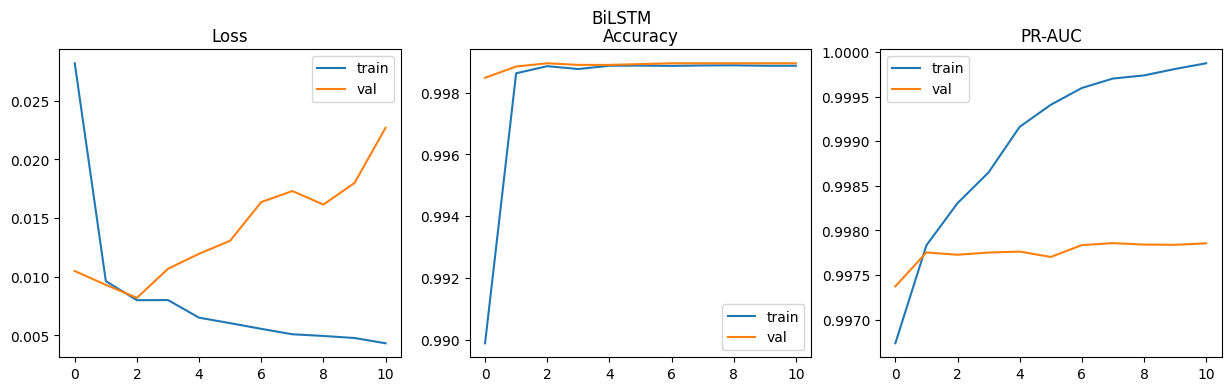

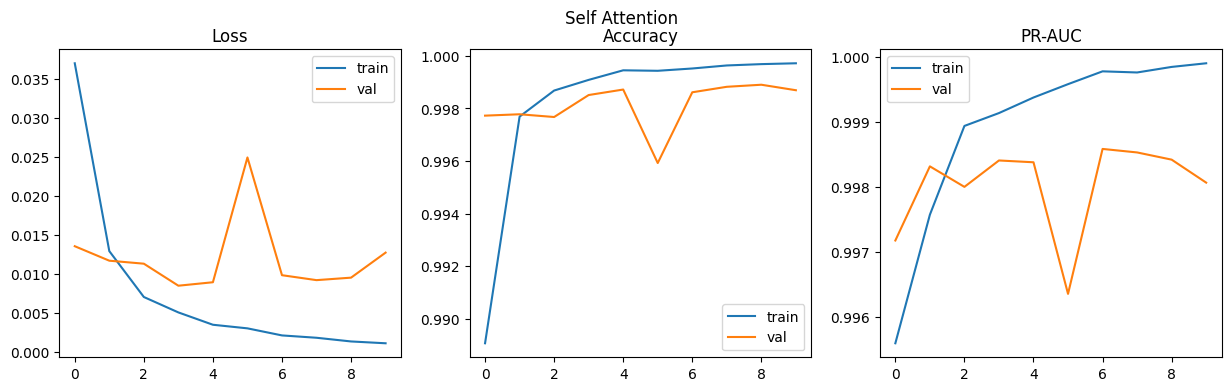

Saved plots to: /content/legal_clause_work/artifacts


In [67]:
def plot_history(hist, title="Training"):
    h = hist.history
    fig, axes = plt.subplots(1, 3, figsize=(15,4))
    axes[0].plot(h["loss"]);     axes[0].plot(h["val_loss"]);     axes[0].set_title("Loss");     axes[0].legend(["train","val"])
    axes[1].plot(h["acc"]);      axes[1].plot(h["val_acc"]);      axes[1].set_title("Accuracy"); axes[1].legend(["train","val"])
    axes[2].plot(h["pr_auc"]);   axes[2].plot(h["val_pr_auc"]);   axes[2].set_title("PR-AUC");   axes[2].legend(["train","val"])
    fig.suptitle(title); plt.show()

    fig.savefig(os.path.join(ART_DIR, f"{title.replace(' ','_').lower()}_curves.png"), dpi=140, bbox_inches="tight")

plot_history(hist_a, "BiLSTM")
plot_history(hist_b, "Self Attention")
print("Saved plots to:", ART_DIR)



=== bilstm (TEST) ===
 accuracy: 0.9988
precision: 0.9975
   recall: 1.0000
       f1: 0.9988
  roc_auc: 0.9986
   pr_auc: 0.9973

Confusion Matrix:
 [[22444    56]
 [    0 22500]]


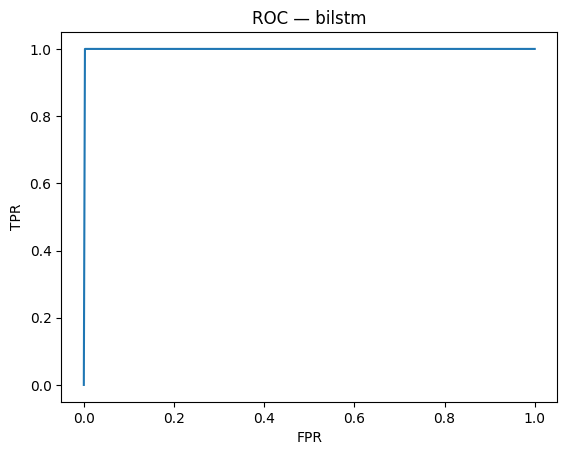

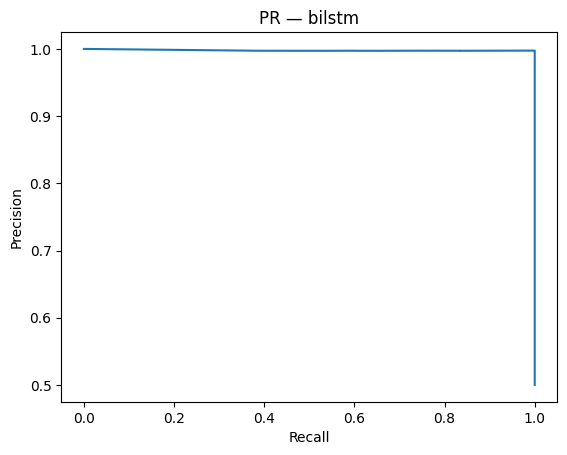

/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:965: UserWarning: Layer 'attention_pooling_1' (of type AttentionPooling) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(



=== self_attention (TEST) ===
 accuracy: 0.9985
precision: 0.9970
   recall: 1.0000
       f1: 0.9985
  roc_auc: 0.9996
   pr_auc: 0.9993

Confusion Matrix:
 [[22433    67]
 [    0 22500]]


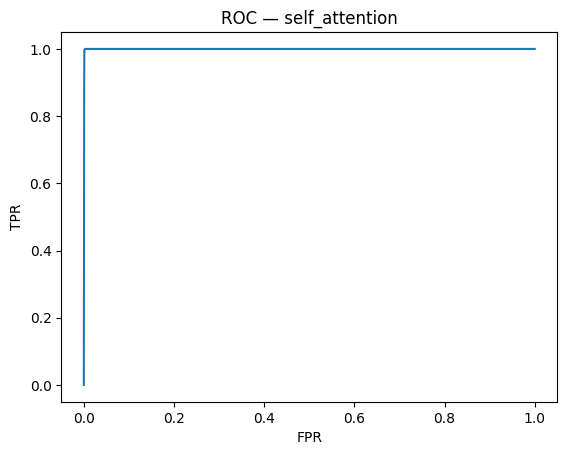

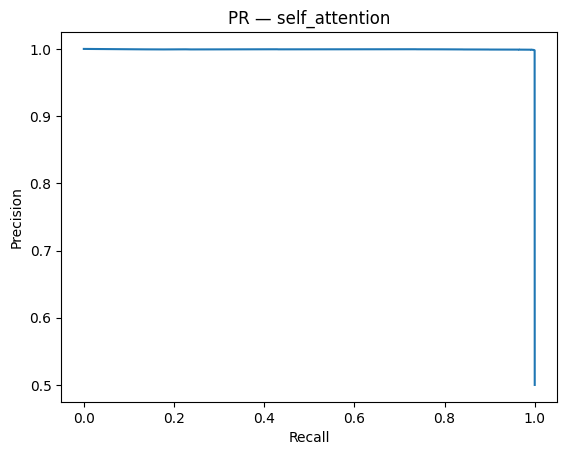

In [68]:
def evaluate_model(model, ds, df_pairs, name="model"):
    y_true = df_pairs["label"].values.astype(int)
    y_prob = model.predict(ds, verbose=0).ravel()
    y_pred = (y_prob >= 0.5).astype(int)

    metrics = {
        "accuracy": accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred, zero_division=0),
        "recall":    recall_score(y_true, y_pred, zero_division=0),
        "f1":        f1_score(y_true, y_pred, zero_division=0),
        "roc_auc":   roc_auc_score(y_true, y_prob),
        "pr_auc":    average_precision_score(y_true, y_prob),
    }

    print(f"\n=== {name} (TEST) ===")
    for k, v in metrics.items(): print(f"{k:>9}: {v:.4f}")
    print("\nConfusion Matrix:\n", confusion_matrix(y_true, y_pred))

    # Curves
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    prec, rec, _ = precision_recall_curve(y_true, y_prob)

    fig1 = plt.figure(); plt.plot(fpr, tpr); plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title(f"ROC — {name}")
    fig1.savefig(os.path.join(ART_DIR, f"roc_{name}.png"), dpi=140, bbox_inches="tight"); plt.show()

    fig2 = plt.figure(); plt.plot(rec, prec); plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title(f"PR — {name}")
    fig2.savefig(os.path.join(ART_DIR, f"pr_{name}.png"), dpi=140, bbox_inches="tight"); plt.show()

    return metrics, y_true, y_prob, y_pred

metrics_a, y_true_a, y_prob_a, y_pred_a = evaluate_model(model_a, ds_test, test_df, "bilstm")
metrics_b, y_true_b, y_prob_b, y_pred_b = evaluate_model(model_b, ds_test, test_df, "self_attention")


In [72]:
def compare_tables(ma, mb, time_a, time_b):
    rows = []
    for k in ["accuracy","precision","recall","f1","roc_auc","pr_auc"]:
        rows.append([k, round(ma[k],4), round(mb[k],4)])
    comp = pd.DataFrame(rows, columns=["metric","BiLSTM","SelfAttention"])
    comp.loc[len(comp)] = ["train_time_sec", round(time_a,1), round(time_b,1)]
    return comp

comp = compare_tables(metrics_a, metrics_b, time_a, time_b)
comp


,metric,BiLSTM,SelfAttention
0,accuracy,0.9988,0.9985
1,precision,0.9975,0.9970
2,recall,1.0000,1.0000
3,f1,0.9988,0.9985
4,roc_auc,0.9986,0.9996
5,pr_auc,0.9973,0.9993
6,train_time_sec,883.7000,154.9000


In [70]:
def show_examples(df_pairs, y_true, y_prob, top_k=3):
    df = df_pairs.copy().reset_index(drop=True)
    df["y_true"] = y_true
    df["p"] = y_prob

    correct_pos = df[(df["y_true"]==1) & (df["p"]>=0.5)].sort_values("p", ascending=False).head(top_k)
    false_pos   = df[(df["y_true"]==0) & (df["p"]>=0.5)].sort_values("p", ascending=False).head(top_k)
    false_neg   = df[(df["y_true"]==1) & (df["p"]<0.5)].sort_values("p", ascending=True ).head(top_k)

    def pretty(block, title):
        print("\n", "="*20, title, "="*20)
        for _, row in block.iterrows():
            print(f"[prob={row.p:.3f} | label={row.y_true}]")
            print("t1:", row.t1[:400])
            print("t2:", row.t2[:400], "\n")

    pretty(correct_pos, "Correctly Predicted Similar")
    pretty(false_pos,   "Incorrect: Predicted Similar but Different")
    pretty(false_neg,   "Incorrect: Missed Similar Pair")

print("\n--- BiLSTM examples ---")
show_examples(test_df, y_true_a, y_prob_a, top_k=3)

print("\n--- Self-Attention examples ---")
show_examples(test_df, y_true_b, y_prob_b, top_k=3)



--- BiLSTM examples ---

 ==================== Correctly Predicted Similar ====================
[prob=1.000 | label=1]
t1: Adjustments. In the event of a stock dividend or in the event the Stock shall be changed into or exchanged for a different number or class of shares of stock of the Company or of another corporation, whether through reorganization, recapitalization, stock split-up, combination of shares, merger or consolidation, there shall be substituted for each such remaining share of Stock then subject to this
t2: Adjustments. If the outstanding shares of Common Stock are subdivided into a greater number of shares (by stock dividend, stock split, reclassification or otherwise) or are combined into a smaller number of shares (by reverse stock split, reclassification or otherwise), or if the Committee determines that any stock dividend, extraordinary cash dividend, reclassification, recapitalization, reorgani 

[prob=1.000 | label=1]
t1: Amendment. The Charter, including the Art

In [71]:
# Save metrics
with open(os.path.join(ART_DIR, "metrics_bilstm.json"), "w") as f:
    json.dump({k: float(v) for k, v in metrics_a.items()}, f, indent=2)
with open(os.path.join(ART_DIR, "metrics_self_attention.json"), "w") as f:
    json.dump({k: float(v) for k, v in metrics_b.items()}, f, indent=2)

# Save models
model_a.save(os.path.join(ART_DIR, "model_bilstm.keras"))
model_b.save(os.path.join(ART_DIR, "model_self_attention.keras"))

print("Saved artifacts to:", ART_DIR)


Saved artifacts to: /content/legal_clause_work/artifacts
